In [ ]:
%load_ext autoreload
%autoreload 2
import sys
import os
# Add the project root (toy-wm directory) to sys.path so we can import src as a package
# This allows relative imports within the package to work correctly
# Assumes notebook is run from the project root directory
project_root = os.getcwd()  # or use: os.path.dirname(os.path.abspath(''))
print(project_root)
if project_root not in sys.path:
    sys.path.insert(0, project_root)

/share/u/wendler/code/toy-wm


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch as t

# Import using absolute path from src package
from src.utils.checkpoint import load_model_from_config

#model = load_model_from_config("configs/inference_vid_6h.yaml", strict=False)
#model = load_model_from_config("configs/inference.yaml", strict=False)
model = load_model_from_config("configs/bigger_30frame_causal_rope_bf16_flex.yaml", strict=False)

model.eval()

In [ ]:
from src.inference import sample
from src.datasets.pong1m import get_loader

loader, pred2frame = get_loader(duration=1, fps=30)
frames, actions = next(iter(loader))

520 batches


In [ ]:
model.dtype

torch.float32

In [ ]:
actions = t.ones(1, 30, dtype=t.int32, device=model.device)*2
actions[:, 0] = 0
z = sample(model, t.randn(1, 30, 3, 24, 24, device=model.device), actions, cfg=0, num_steps=1)
print(z.mean(), z.std())


tensor(nan) tensor(nan)


tensor(nan) tensor(nan)
tensor(0.) tensor(0.)


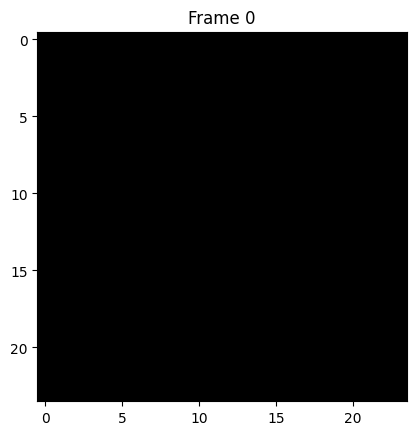

In [ ]:
print(z.mean(), z.std())
frames = pred2frame(z)
print(frames.float().mean(), frames.float().std())
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# z[0] shape: (num_frames, height, width, 3), where num_frames = frames.shape[1]
frames_np = frames[0].permute(0, 2, 3, 1).cpu().numpy()  # shape: (num_frames, height, width, 3)

fig, ax = plt.subplots()
im = ax.imshow(frames_np[0])
ax.set_title('Frame 0')

def animate(i):
    im.set_data(frames_np[i])
    ax.set_title(f'Frame {i}')
    return [im]

ani = animation.FuncAnimation(
    fig, animate, frames=frames_np.shape[0],
    interval=200, blit=True, repeat=True
)

plt.show()

ani.save("sample_joint.gif", writer="pillow")

In [ ]:
cache = model.create_cache(1)

In [ ]:
from src.trainers.diffusion_forcing import sample

def render_video(actions, n_steps=4, cfg=0, negative_actions=None, clamp=True, cache=cache):
    cache.reset()
    device = model.device
    frames = t.randn(1, actions.shape[1], 3, 24, 24, device="cpu")
    for aidx in range(actions.shape[1]):
        print(aidx)
        noise=t.randn(1, 1, 3, 24, 24, device=model.device)
        z = sample(model, noise, actions[:, aidx:aidx+1], num_steps=n_steps, cfg=cfg, negative_actions=negative_actions, cache=cache)
        frames[:, aidx:aidx+1] = z.detach().cpu()
        if clamp:
            frames = frames.clamp(-1, 1)
    return frames

In [ ]:
actions = t.tensor([0, 2, 2, 2, 2], dtype=t.int32, device=model.device).repeat(50).unsqueeze(0)
z = render_video(actions, n_steps=8, cfg=0, negative_actions=None, clamp=True)
frames = pred2frame(z)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249


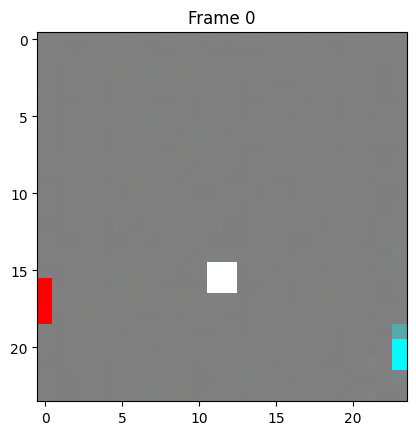

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# z[0] shape: (num_frames, height, width, 3), where num_frames = frames.shape[1]
frames_np = frames[0].permute(0, 2, 3, 1).cpu().numpy()  # shape: (num_frames, height, width, 3)

fig, ax = plt.subplots()
im = ax.imshow(frames_np[0])
ax.set_title('Frame 0')

def animate(i):
    im.set_data(frames_np[i])
    ax.set_title(f'Frame {i}')
    return [im]

ani = animation.FuncAnimation(
    fig, animate, frames=frames_np.shape[0],
    interval=200, blit=True, repeat=True
)

plt.show()

# Optional: To save the gif uncomment below (requires pillow, install with `pip install pillow`)
from collections import Counter
# Majority vote over values in actions for the filename
if actions is not None:
    # Flatten actions tensor and convert to list
    action_vals = actions.flatten().tolist()
    majority_val = Counter(action_vals).most_common(1)[0][0]
    ani.save(f"sample_{majority_val}.gif", writer="pillow")
else:
    ani.save("sample_unknown.gif", writer="pillow")